In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from configobj import ConfigObj
from itertools import chain
import os, glob
import shutil
import pandas as pd
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.constants as const
from dustmaps.sfd import SFDQuery
from dust_extinction.parameter_averages import CCM89, G23
from scipy.stats import kstest, anderson_ksamp, PermutationMethod, gaussian_kde
from tqdm import tqdm

In [2]:
#define paramters to be modified in default config file
#for any section that requires paramters to be edited, include it in 'sed_modules_params'
CIGALE_PARAMS = {'sed_modules': ['sfhdelayed', 'bc03', 'nebular', 'dustatt_calzleit', 'dale2014', 'redshifting'],
                 'analysis_method': "pdf_analysis",
                 'sed_modules_params': {
                     'sfhdelayed': {
                        'tau_main': ['250', '500', '1000', '2000', '4000', '6000', '8000'],
                        'age_main': ['250', '500', '1000', '2000', '4000', '8000', '12000'],
                     },
                     'bc03': {
                         'imf': 1,
                         'metallicity': ['0.0001', '0.0004', '0.004', '0.008', '0.02', '0.05'],
                     },
                     'dustatt_calzleit': {
                         'E_BVs_young': ['0.0', '0.2', '0.3', '0.5', '0.8', '1.0', '1.5', '2.0', '3.0'],
                         'E_BVs_old_factor': ['0.3', '0.5', '1.0'],
                         'uv_bump_amplitude': ['0.0', '1.0', '2.0', '3.0'],
                         'powerlaw_slope': ['-0.13', '-0.2', '-0.5']
                     },
                     'dale2014': {
                         'alpha': ['1.0', '1.5', '2.0', '2.5'],
                     }
                 },
                 'analysis_params': {
                     'save_best_sed': True,
                 }}

In [3]:
CIGALE_PTF_FILTERS = ['GALEX_FUV', 'GALEX_NUV', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z',
                      'PANSTARRS_g', 'PANSTARRS_r', 'PANSTARRS_i', 'PANSTARRS_z', 'PANSTARRS_y',
                      'CFHT_u', 'CFHT_g', 'CFHT_r', 'CFHT_i', 'CFHT_z', 'LS_g', 'LS_r', 'LS_z',
                      '2MASS_J', '2MASS_H', '2MASS_Ks', 'WISE_W1', 'WISE_W2']

In [4]:
pivot_lambda = [153.51*u.nm, 230.08*u.nm, 350.10*u.nm, 476.31*u.nm, 624.70*u.nm, 771.83*u.nm, 1.08*u.um,
                484.91*u.nm, 620.12*u.nm, 753.50*u.nm, 867.42*u.nm, 962.78*u.nm,
                364.75*u.nm, 474.15*u.nm, 637.55*u.nm, 767.88*u.nm, 900.66*u.nm, 480.85*u.nm, 641.76*u.nm, 916.89*u.nm,
                1.24*u.um, 1.65*u.um, 2.16*u.um, 3.37*u.um, 4.62*u.um]
CIGALE_PTF_LAMBDA = dict(zip(CIGALE_PTF_FILTERS, pivot_lambda))

In [5]:
def prep_cigale(data_file, params):

    subprocess.run(["pcigale", "init"])
    configfile = 'pcigale.ini'

    #read in configfile
    config = ConfigObj(configfile, encoding = 'utf-8')
    config.filename = configfile

    #edit params
    config['data_file'] = data_file
    config['sed_modules'] = params['sed_modules']
    config['analysis_method'] = params['analysis_method']
    config.write()
    
    #generate config file to run cigale
    try:
        subprocess.run(["pcigale", "genconf"])
    except:
        raise ValueError("Could not create config file - check defaults")
    
    #read configfile again as it has been modified by genconf
    config = ConfigObj(configfile, encoding = 'utf-8')
    config.filename = configfile
    
    #genconf will overwrite any edits, so modify paramters at the end
    for module_ in params['sed_modules']:
        if module_ in params['sed_modules_params'].keys():
            mod = params['sed_modules_params'][module_]
            for key, value in mod.items():
                config['sed_modules_params'][module_][key] = value

    if 'analysis_params' in params.keys():
        for key, value in params['analysis_params'].items():
            config['analysis_params'][key] = value
    config.write()

    #verify if config file is ok
    try:
        subprocess.run(["pcigale", "check"])
    except:
        raise ValueError("Config file in incorrect")
    
    return config

In [6]:
def run_cigale(configfile, data_file, outdir, plot=False):
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    #copy everything to outdir
    shutil.copy(configfile, os.path.join(outdir, configfile))
    shutil.copy(configfile + '.spec', os.path.join(outdir, configfile + '.spec'))
    shutil.copy(data_file, os.path.join(outdir, data_file))

    cwd = os.getcwd()
    os.chdir(outdir)

    #run cigale
    subprocess.run(["pcigale", "run"])
    if plot:
        subprocess.run(["pcigale-plots", "sed"])
    os.chdir(cwd)

In [7]:
def read_ptf_sample(filename):
    try:
        ptf_sne = pd.read_csv(filename, header = None, names=['SN', 'telescope', 'instrument', 'filter', 'mag', 'magerr', 'ref'])
        ptf_sne['SN'] = ptf_sne['SN'].str.strip()
        ptf_sne['telescope'] = ptf_sne['telescope'].str.strip()
        ptf_sne['instrument'] = ptf_sne['instrument'].str.strip()
        ptf_sne['filter'] = ptf_sne['filter'].str.strip()
        ptf_sne['ref'] = ptf_sne['ref'].str.strip()
        
        return ptf_sne
    except:
        raise ValueError('Reformat input file with correct whitespaces and delimiters')

In [8]:
def read_ptf_redshifts(filename):
    try:
        redshifts = pd.read_csv(filename, header = None, usecols = [0, 1, 2, 5, 6, 7, 8, 9, 10],  names = ['SN', 'Type', 'z', 'RAh', 'RAm', 'RAs', 'Decd', 'Decm', 'Decs'])
        redshifts['RA'] = redshifts['RAh'].astype(str) + ':' + redshifts['RAm'].astype(str) + ':' + redshifts['RAs'].astype(str)
        redshifts['Dec'] = redshifts['Decd'].astype(str) + ':' + redshifts['Decm'].astype(str) + ':' + redshifts['Decs'].astype(str)
        redshifts = redshifts.drop(columns=['RAh', 'RAm', 'RAs', 'Decd', 'Decm', 'Decs'])
        redshifts['SN'] = redshifts['SN'].str.strip()
        redshifts['Type'] = redshifts['Type'].str.strip()

        return redshifts
    
    except:
        raise ValueError('Reformat input file with correct whitespaces and delimiters')

In [9]:
def mw_extinction(sn, redshifts, filters, verbose=False):
    #get SN coordinates from redshifts table
    ra = redshifts[redshifts['SN'] == sn]['RA']
    dec = redshifts[redshifts['SN'] == sn]['Dec']
    coord = SkyCoord(ra=ra, dec=dec, unit = (u.hourangle, u.deg), frame='icrs')

    #query SFD dust map for E(B-V)
    sfd = SFDQuery()
    ebv = sfd(coord)[0]
    R_V = 3.1

    #use extinction law from Gordon+23
    ext = G23(Rv = R_V)
    out_ext = dict.fromkeys(filters)
    for flt_ in filters:
        wv = CIGALE_PTF_LAMBDA[flt_]
        a_lambda = ext(wv)
        A_lambda = a_lambda * ebv * R_V
        if verbose:
            print(f'A_lambda for {sn} in {flt_} is {A_lambda}')
        out_ext[flt_] = A_lambda

    return out_ext

In [10]:
def get_sn_data(sn, ptf_sne, redshifts, verbose=False):

    #read mags, redshift and filters
    dat = ptf_sne[ptf_sne['SN'].str.lower() == sn.lower()]
    z = redshifts[redshifts['SN'].str.lower() == sn.lower()]['z'].iloc[0]
    filters = dat['telescope'] + '_' + dat['filter']
    mag, err = np.array(dat['mag']), np.array(dat['magerr'])

    maglist, errlist = [], []
    for f in CIGALE_PTF_FILTERS:
        if f in list(filters):
            idx = list(filters).index(f)
            # Correct photometry for MW extinction
            mwext = mw_extinction(sn, redshifts, [f], verbose=verbose)[f]
            if verbose:
                print(f'MW extinction for {sn} in {f}: {mag[idx]} -> {mag[idx] - mwext}')
            maglist.append(mag[idx] - mwext); errlist.append(err[idx])
        else:
            maglist.append(np.nan); errlist.append(np.nan)

    maglist, errlist = np.array(maglist), np.array(errlist)
    phot_points = len(maglist[~np.isnan(maglist)])

    #convert magnitudes to flux in mJy as required by CIGALE
    flux = 10**((maglist - 8.90)/-2.5)*1000
    fluxerr = errlist * flux * np.log(10)/2.5

    #output string for CIGALE data file
    line = [f'{i} {j}' for i, j in zip(flux, fluxerr)]
    line = ' '.join(line)
    row = f'{sn} {z} ' + line

    return row, phot_points

In [11]:
def prep_cigale_datafile(filename, sne, ptf_sne, redshifts, verbose=False):
    rows = []
    #get extinction corrected photomtery
    for sn in sne:
        row_, phot_points = get_sn_data(sn, ptf_sne, redshifts, verbose=verbose)
        if phot_points < 4:
            print(f'Skipping {sn} with {phot_points} data points')
            continue
        else:
            rows.append(row_)
    
    #write out into datafile
    with open(filename, 'a') as f:
        f.write('\n'.join(rows))

In [12]:
def create_results_table(paths, savedir, type = 'FBOT', overwrite = False):
    res_tables, obs_tables = [], []
    for path_ in paths:
        res_tables.append(Table(fits.getdata(os.path.join(path_, 'out/results.fits'), ext=1)))
        obs_tables.append(Table(fits.getdata(os.path.join(path_, 'out/observations.fits'), ext=1)))

    results, observations = vstack(res_tables), vstack(obs_tables)    
    if 'Type' in type:
        types = type.loc[type.index[type['SN'].isin(results['id'])].tolist()]['Type']
        results['type'] = types
        out_prefix = 'sne'
    else:
        results['type'] = type
        out_prefix = 'fbots'
        
    ascii.write(results, os.path.join(savedir, f'{out_prefix}_results.dat'), overwrite=overwrite)
    ascii.write(observations, os.path.join(savedir, f'{out_prefix}_observations.dat'), overwrite=overwrite)
    
    return results, observations

In [13]:
ptf_sne = read_ptf_sample('ptf_ccsne.csv')
ptf_sne = ptf_sne[ptf_sne['ref'] == 'This paper']

redshifts = read_ptf_redshifts('ptf_ccsne_redshifts.csv')
redshifts = redshifts[redshifts['SN'].isin(ptf_sne['SN'])]

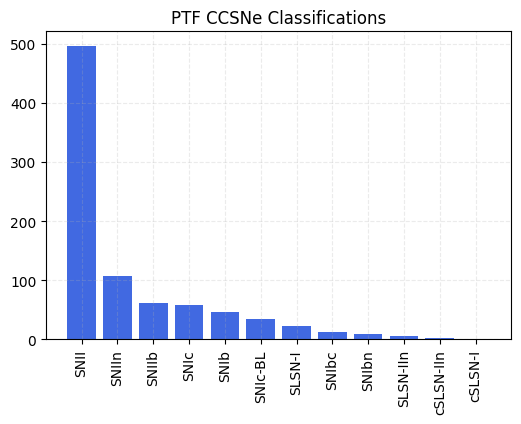

In [14]:
types, counts = np.unique(redshifts['Type'], return_counts=True)
sort = np.argsort(counts)[::-1]
types, counts = types[sort], counts[sort]
plt.figure(figsize = (6, 4))
plt.bar(*(types, counts), color = 'royalblue')
plt.grid(alpha = 0.25, linestyle = '--')
plt.title('PTF CCSNe Classifications')
_ = plt.xticks(rotation = 90)

In [19]:
# Narrow line SNe
type_n = ['SNIIn', 'SNIbn']
narrow_sne = redshifts[redshifts['Type'].isin(type_n)]['SN'].to_numpy()

# Type Ibc SNe
type_Ibc = ['SNIb', 'SNIbc', 'SNIc', 'SNIc-BL']
type_Ibc_sne = redshifts[redshifts['Type'].isin(type_Ibc)]['SN'].to_numpy()

# Superluminous SNe
sl_sne = redshifts[redshifts['Type'].str.contains('SLSN')]['SN'].to_numpy()

# Type II SNe
type_II = ['SNII', 'SNIIb']
type_II_sne = redshifts[redshifts['Type'].isin(type_II)]['SN'].to_numpy()

# All CCSNe
sne_list = redshifts['SN'].to_numpy()

In [21]:
data_file = 'ptf_ccsne_cigale.txt'
ptf = True
if ptf:
    prep_cigale_datafile(data_file, sne_list, ptf_sne, redshifts, verbose=False)

Skipping PTF09be with 3 data points
Skipping PTF09dh with 3 data points
Skipping PTF09gyp with 2 data points
Skipping PTF10aako with 1 data points
Skipping PTF10abkc with 3 data points
Skipping PTF10absf with 3 data points
Skipping PTF10ikr with 3 data points
Skipping PTF10jwd with 2 data points
Skipping PTF10uhf with 1 data points
Skipping PTF11fvi with 3 data points
Skipping PTF11hrq with 2 data points
Skipping PTF11po with 2 data points
Skipping PTF11rks with 1 data points
Skipping PTF12esl with 3 data points
Skipping PTF12grr with 3 data points
Skipping PTF12mfx with 2 data points
Skipping PTF12mhg with 2 data points
Skipping PTF12th with 3 data points
Skipping iPTF13ajg with 2 data points
Skipping iPTF13ala with 3 data points
Skipping iPTF13bjz with 2 data points
Skipping iPTF13bu with 2 data points
Skipping iPTF13cjq with 3 data points
Skipping iPTF13cuf with 2 data points
Skipping iPTF13dcc with 2 data points
Skipping iPTF13dol with 3 data points
Skipping iPTF13ehe with 3 data p

In [22]:
config = prep_cigale(data_file, CIGALE_PARAMS)

╭──────────────────────────────────────────────────────────────────────────────╮
│                      Code Investigating GALaxy Emission                      │
│                Boquien et al. (2019) (]8;id=679540;https://cigale.lam.fr\https://cigale.lam.fr]8;;\)                 │
│         CIGALE version: 2025.0 — Python version: 3.12.0 — Platform:          │
│                              macosx-11.1-arm64                               │
╰───────────────────────────���──────────────────────────────────────────────────╯


                                  SED modules                                   
╭──────────────────────┬───────────────────────────────────────────────────────╮
│ SFH                  │ None. Options are: sfh2exp, sfh_buat08, sfhdelayed,   │
│                      │ sfhdelayedbq, sfhfromfile, sfhperiodic.               │
│ SSP                  │ None. Options are: bc03, bpassv2, cb19, m2005.        │
│ nebular              │ None. Options are: nebular.         

In [23]:
run_cigale('pcigale.ini', data_file, 'ptfccsne', plot=True)

╭──────────────────────────────────────────────────────────────────────────────╮
│                      Code Investigating GALaxy Emission                      │
│                Boquien et al. (2019) (]8;id=825014;https://cigale.lam.fr\https://cigale.lam.fr]8;;\)                 │
│         CIGALE version: 2025.0 — Python version: 3.12.0 — Platform:          │
│                              macosx-11.1-arm64                               │
╰───────────────────────────���──────────────────────────────────────────────────╯


                              General information                               
╭───────────────────┬──────────────────────────────────────────────────────────╮
│ Data file         │ ptf_ccsne_cigale.txt                                     │
│ Parameters file   │ None                                                     │
│ Number of objects │ 817                                                      │
│ Redshift          │ 0.00 to 0.94                           

In [127]:
sne_results, sne_obs = create_results_table(['ptfIIsne', 'ptfIbcsne', 'ptfnarrowsne', 'ptfslsne'], '.', type=redshifts, overwrite=True)
fbot_results, fbot_obs = create_results_table(['ztffbots'], '.', type='FBOT', overwrite=True)

In [128]:
sne_obs

id,redshift,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,sloan.sdss.uprime,sloan.sdss.uprime_err,sloan.sdss.gprime,sloan.sdss.gprime_err,sloan.sdss.rprime,sloan.sdss.rprime_err,sloan.sdss.iprime,sloan.sdss.iprime_err,sloan.sdss.zprime,sloan.sdss.zprime_err,panstarrs.ps1.g,panstarrs.ps1.g_err,panstarrs.ps1.r,panstarrs.ps1.r_err,panstarrs.ps1.i,panstarrs.ps1.i_err,panstarrs.ps1.z,panstarrs.ps1.z_err,panstarrs.ps1.y,panstarrs.ps1.y_err,cfht.megaprime.u,cfht.megaprime.u_err,cfht.megaprime.g,cfht.megaprime.g_err,cfht.megaprime.r,cfht.megaprime.r_err,cfht.megaprime.i,cfht.megaprime.i_err,cfht.megaprime.z,cfht.megaprime.z_err,ctio.ls.g,ctio.ls.g_err,ctio.ls.r,ctio.ls.r_err,ctio.ls.z,ctio.ls.z_err,2mass.J,2mass.J_err,2mass.H,2mass.H_err,2mass.Ks,2mass.Ks_err,wise.W1,wise.W1_err,wise.W2,wise.W2_err
str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
PTF09axi,0.064,nan,nan,nan,nan,0.03164126886132307,0.0051631291852094,0.1143414228445763,0.013063923291603238,0.15011400802552272,0.01715107121332769,0.1902000468008898,0.02173104689141126,0.1985024927585646,0.028257493771710617,0.1033000125036866,0.012290829843768893,0.14337101909922026,0.017058553600982074,0.17673912879925985,0.02019308806745216,0.18140831343546007,0.02466288352295994,0.17627674775676713,0.0369476012446467,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PTF09bgf,0.0318,0.04853382733675712,0.013842128424791215,0.04960031459190063,0.007060770679390103,0.08817927202638155,0.015038853522199242,0.18925728282804336,0.022518187593157456,0.23190089294616936,0.026495520182751996,0.2721167452776549,0.0338007377337764,0.25569112812792744,0.05153541015665101,0.1789927436753904,0.026678670745393485,0.20959788769347706,0.029836960351252755,0.22439447103743793,0.03050695195598881,0.2975711494375065,0.04236024840301815,0.3285628274281657,0.058514239667197585,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.15014922200898265,0.025607743230060827,0.07453085675303046,0.014429959154233476
PTF09bw,0.147,nan,nan,nan,nan,nan,nan,0.015068102900780724,0.0022458840944785618,0.03098622137860965,0.0036867989193346265,0.037428785528739905,0.004861603030862205,0.03395184318152809,0.010863543238028062,0.016515480695986805,0.0021451861147379,0.028264006286171744,0.0032292654827100046,0.034785936102961566,0.004138896126294848,0.040955137855103324,0.005830100855548069,0.045662432816409304,0.007787665091948056,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.038761725352491117,0.00781255661487264,0.022297645955711164,0.006359417664465263
PTF09cjq,0.01929,0.6237268664539338,0.08878960560715762,0.8854492552184902,0.12037889241892158,3.45370314105002,0.41092809776785866,12.296853861925646,1.4049602636011957,23.929592838858554,2.7340429869504197,33.69457531316892,3.8497277389378466,41.95258740484957,4.793235645547435,12.054943517040323,1.3271808062961643,22.448117331457215,2.4714102075783817,30.500277993377956,3.3579073582790904,33.43399830040007,3.680893299857104,41.818912009844674,4.777962745640527,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,55.0205330221343,6.546446538565386,62.70014407088008,7.460181110118253,54.87004209572429,7.810934015117202,30.58543099108371,4.158160713516551,16.787005097730265,2.3896863228399967
PTF09cu,0.05692,0.11046113781805901,0.015017449444452501,0.15414819049521897,0.020956806198472136,0.36040556202142143,0.039678605189736156,1.0730195772643933,0.11813336045185914,1.805964397890852,0.19882642190292152,2.4401680350616206,0.2686486399287851,2.923351153702411,0.33400349

(-3.0, 3.0)

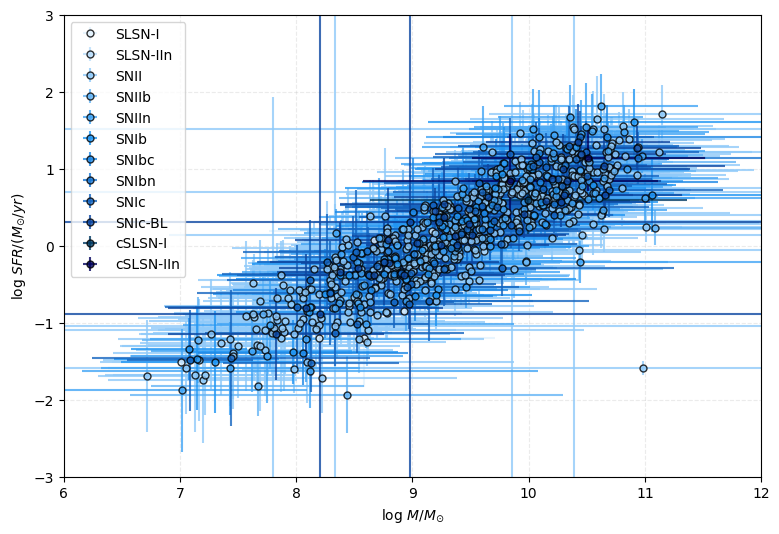

In [140]:
subtypes = np.unique(sne_results['type'])
sfr_m_colors = np.array(['#e3f2fd', '#bbdefb', '#90caf9', '#64b5f6', '#42a5f5', 
                         '#2196f3', '#1e88e5', '#1976d2', '#1565c0', '#0d47a1',
                         '#013a63', '#03045e'])
fig, ax = plt.subplots(1, 1, figsize = (9, 6))
for type_, col_ in zip(subtypes, sfr_m_colors):
    subtable_ = sne_results[sne_results['type'] == type_]
    ax.errorbar(np.log10(subtable_['bayes.stellar.m_star']), np.log10(subtable_['bayes.sfh.sfr']), 
                yerr =  subtable_['bayes.stellar.m_star_err']/subtable_['bayes.stellar.m_star'], 
                xerr = subtable_['bayes.sfh.sfr_err']/subtable_['bayes.sfh.sfr'],
                marker = 'o',  markeredgecolor = 'black', markerfacecolor = col_, 
                ecolor = col_, markersize = 5, linestyle = 'none', label = type_, alpha = 0.8)

ax.grid(alpha = 0.25, linestyle = '--')
ax.set_xlabel(r'log $M/M_{\odot}$')
ax.set_ylabel(r'log $SFR/(M_{\odot}/yr)$')
ax.legend()
ax.set_xlim(6, 12)
ax.set_ylim(-3, 3)

(-3.0, 2.0)

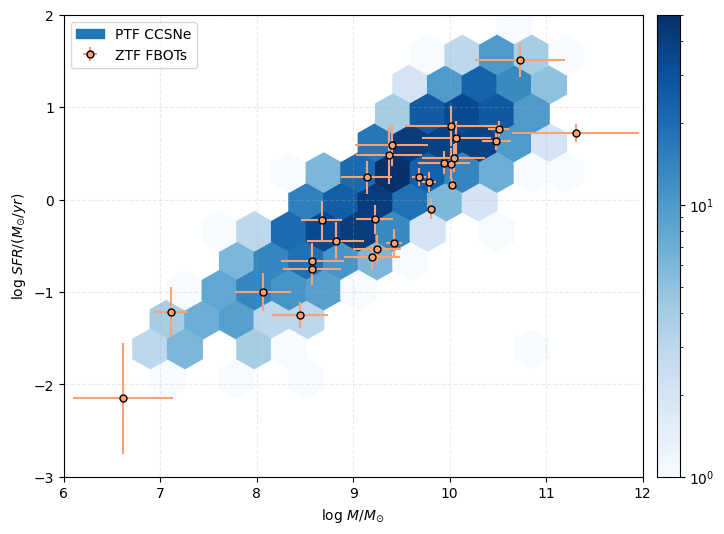

In [157]:
fig, ax = plt.subplots(1, 1, figsize = (9, 6))
ax.errorbar(np.log10(fbot_results['bayes.stellar.m_star']), np.log10(fbot_results['bayes.sfh.sfr']), 
            yerr = fbot_results['bayes.stellar.m_star_err']/fbot_results['bayes.stellar.m_star']/np.log(10), 
            xerr = fbot_results['bayes.sfh.sfr_err']/fbot_results['bayes.sfh.sfr']/np.log(10),
            marker = 'o', markerfacecolor = "#faa275", markeredgecolor = 'black', 
            ecolor = '#faa275', markersize = 5, linestyle = 'none', label = 'ZTF FBOTs')
im_ = ax.hexbin(np.log10(sne_results['bayes.stellar.m_star']), np.log10(sne_results['bayes.sfh.sfr']), gridsize = 15, cmap = 'Blues', norm='log', label = 'PTF CCSNe')
fig.colorbar(im_, pad = 0.02)
ax.grid(alpha = 0.25, linestyle = '--')
ax.set_xlabel(r'log $M/M_{\odot}$')
ax.set_ylabel(r'log $SFR/(M_{\odot}/yr)$')
ax.legend()
ax.set_xlim(6, 12)
ax.set_ylim(-3, 2)

Text(0.5, 1.0, 'Host Extinction')

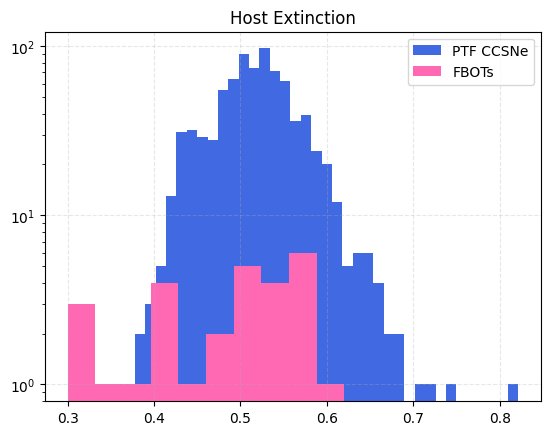

In [236]:
plt.hist(sne_results['bayes.attenuation.ebvs_old_factor'], bins = 40, color = 'royalblue', label = 'PTF CCSNe')
plt.hist(fbot_results['bayes.attenuation.ebvs_old_factor'], bins = 10, color = 'hotpink', label = 'FBOTs')
plt.yscale('log')
plt.grid(linestyle = '--', alpha = 0.3)
plt.legend()
plt.title('Host Extinction')

In [206]:
def monte_carlo_sims_1d(fbot_pop_var, sne_pop_var, nsim = 1000):
    len_samp = len(fbot_pop_var)
    #statistics for observed population of FBOTs
    #two-sided null hypothesis KS test
    ks_stats_obs = kstest(fbot_pop_var, sne_pop_var, alternative='two_sided')

    #Anderson-Darling test
    rng = np.random.default_rng()
    ad_method = PermutationMethod(n_resamples=9999, random_state=rng)
    ad_stats_obs = anderson_ksamp([fbot_pop_var, sne_pop_var], method=ad_method)

    print(f'KS test on observed distribution: stat {ks_stats_obs.statistic}, pval {ks_stats_obs.pvalue}')
    print(f'AD test on observed distribution: stat {ad_stats_obs.statistic}, pval {ad_stats_obs.pvalue}')

    kernel = gaussian_kde(sne_pop_var)
    mc_stats = {'KS': [], 'AD': [], 'p1': [], 'p2': []}
    for i in tqdm(range(nsim)):
        smp_ = kernel.resample(len_samp)[0]
        ks_smp = kstest(smp_, sne_pop_var, alternative='two_sided')
        ad_smp = anderson_ksamp([smp_, sne_pop_var], method=ad_method)
        mc_stats['KS'].append(ks_smp.statistic); mc_stats['AD'].append(ad_smp.statistic)
        mc_stats['p1'].append(ks_smp.pvalue); mc_stats['p2'].append(ad_smp.pvalue)

    ks_pval = (mc_stats['KS'] > ks_stats_obs.statistic).sum()/nsim
    ad_pval = (mc_stats['AD'] > ad_stats_obs.statistic).sum()/nsim

    print(f'Monte Carlo p-values: KS {ks_pval} AD {ad_pval}')

    return mc_stats, ks_pval, ad_pval

In [237]:
mc_stats, ks_pval, ad_pval = monte_carlo_sims_1d(np.log10(fbot_results['bayes.attenuation.ebvs_old_factor']), np.log10(sne_results['bayes.attenuation.ebvs_old_factor']))

KS test on observed distribution: stat 0.28715684560237803, pval 0.017986835142329002
AD test on observed distribution: stat 7.439860949860264, pval 0.0007


100%|██████████| 1000/1000 [13:18<00:00,  1.25it/s]

Monte Carlo p-values: KS 0.017 AD 0.0


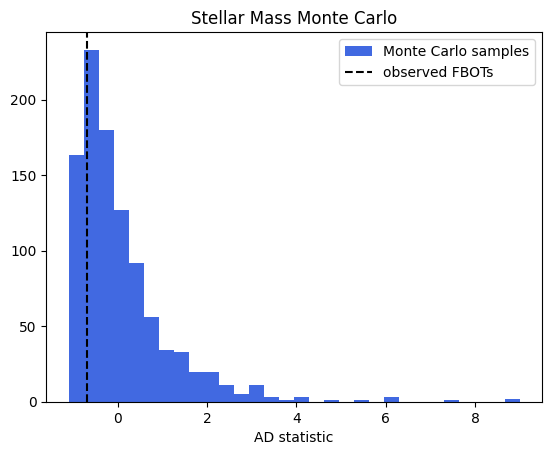

In [221]:
plt.hist(mc_stats['AD'], bins = 30, color = 'royalblue', label = 'Monte Carlo samples')
plt.axvline(-0.6771259359113175, linestyle = '--', alpha = 1, color = 'black', label = 'observed FBOTs')
plt.xlabel('AD statistic')
plt.title('Stellar Mass Monte Carlo')
plt.legend()

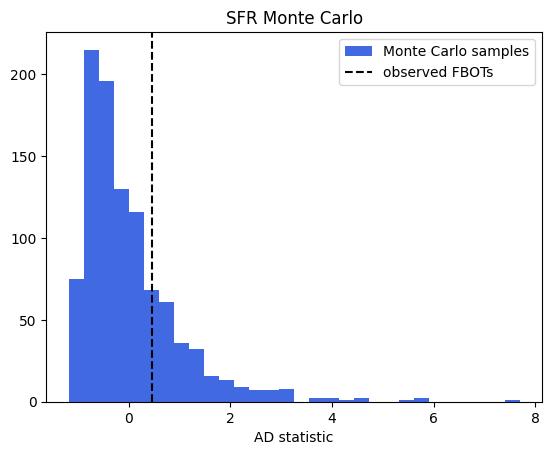

In [223]:
plt.hist(mc_stats['AD'], bins = 30, color = 'royalblue', label = 'Monte Carlo samples')
plt.axvline(0.4613451165065528, linestyle = '--', alpha = 1, color = 'black', label = 'observed FBOTs')
plt.xlabel('AD statistic')
plt.title('SFR Monte Carlo')
plt.legend()

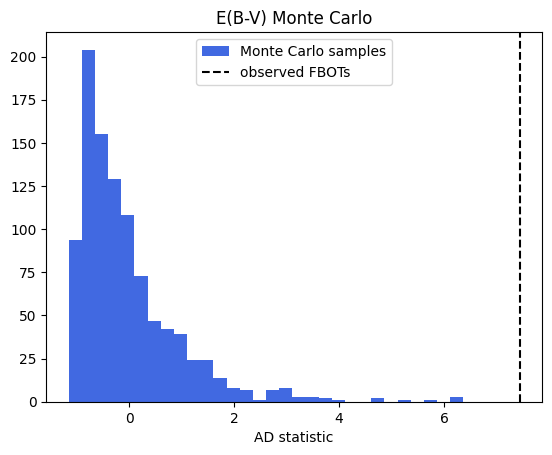

In [238]:
plt.hist(mc_stats['AD'], bins = 30, color = 'royalblue', label = 'Monte Carlo samples')
plt.axvline(7.439860949860264, linestyle = '--', alpha = 1, color = 'black', label = 'observed FBOTs')
plt.xlabel('AD statistic')
plt.title('E(B-V) Monte Carlo')
plt.legend()